<a href="https://colab.research.google.com/github/Paridhi004/UCS654-ASSIGNMENT2/blob/main/PA_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter


file_path = "data.csv"


df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shrutibhargava94/india-air-quality-data",
  file_path,
  pandas_kwargs={'encoding': 'latin1'}
)

print("First 5 records:", df.head())

/tmp/ipython-input-3365438184.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'india-air-quality-data' dataset.
First 5 records:   stn_code       sampling_date           state   location agency  \
0    150.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1    151.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2    152.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3    150.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4    151.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN   

  location_monitoring_station  pm2_5        date  
0                         NaN    NaN  1990-02-01  
1               

/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


## Get Transformation Parameters



In [4]:
r = int(input("Please enter your university roll number: "))
a_r = 0.5 * (r % 7)
b_r = 0.3 * (r % 5 + 1)

print(f"Calculated a_r: {a_r}")
print(f"Calculated b_r: {b_r}")

Please enter your university roll number: 102303715
Calculated a_r: 1.5
Calculated b_r: 0.3


## Generate and Transform Data




In [5]:
import numpy as np

# Ensure df is available from previous cells. If not, load it.
# This assumes df has been loaded and contains 'no2' column

# Extract NO2 values, convert to numeric, and drop NaNs
x = df['no2'].dropna().values.astype(float)

# Define the number of samples to generate if x is to be constrained
# For this task, we will use all available valid NO2 samples
num_samples = len(x)

# Apply the transformation function
z = x + a_r * np.sin(b_r * x)

print(f"Shape of x samples (NO2 values): {x.shape}")
print(f"Shape of z samples (transformed NO2): {z.shape}")
print(f"First 5 x samples: {x[:5]}")
print(f"First 5 z samples: {z[:5]}")

Shape of x samples (NO2 values): (419509,)
Shape of z samples (transformed NO2): (419509,)
First 5 x samples: [17.4  7.  28.5 14.7  7.5]
First 5 z samples: [16.08913761  8.29481405 29.65110174 13.26805834  8.6671098 ]


## Define GAN Architecture




In [6]:
import torch
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)


latent_dim = 100
hidden_dim = 256

generator = Generator(latent_dim, hidden_dim)
discriminator = Discriminator(hidden_dim)

print("Generator network:")
print(generator)
print("\nDiscriminator network:")
print(discriminator)

Generator network:
Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Tanh()
  )
)

Discriminator network:
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


## Train GAN



In [7]:
import torch.utils.data as data

# 1. Define hyperparameters for training
num_epochs = 500
batch_size = 256
learning_rate = 0.0002
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move models to the device
generator.to(device)
discriminator.to(device)

# 2. Convert the real z samples to a PyTorch tensor and move to device
# Reshape z to (num_samples, 1) to match discriminator input
real_z_tensor = torch.from_numpy(z).float().view(-1, 1).to(device)

# Create a DataLoader for the real data
real_data_loader = data.DataLoader(real_z_tensor, batch_size=batch_size, shuffle=True)

# 3. Initialize the Binary Cross-Entropy (BCE) loss function
criterion = nn.BCEWithLogitsLoss() # nn.BCEWithLogitsLoss combines sigmoid and BCE loss

# 4. Initialize Adam optimizers for both Generator and Discriminator
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# 5. Implement the training loop
print("Starting GAN training...")
for epoch in range(num_epochs):
    for i, real_samples in enumerate(real_data_loader):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_d.zero_grad()

        # a. Train with real samples
        real_labels = torch.ones(real_samples.size(0), 1).to(device) # Labels for real samples are 1
        output_real = discriminator(real_samples)
        d_loss_real = criterion(output_real, real_labels)

        # b. Train with fake samples
        noise = torch.randn(real_samples.size(0), latent_dim).to(device) # Generate noise
        fake_samples = generator(noise) # Generate fake samples
        fake_labels = torch.zeros(real_samples.size(0), 1).to(device) # Labels for fake samples are 0
        output_fake = discriminator(fake_samples.detach()) # Detach to prevent gradient flow to generator
        d_loss_fake = criterion(output_fake, fake_labels)

        # c. Combine and optimize Discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # -------------------
        #  Train Generator
        # -------------------
        optimizer_g.zero_grad()

        # Generate new fake samples
        noise = torch.randn(real_samples.size(0), latent_dim).to(device) # Generate new noise
        fake_samples = generator(noise)
        # Generator wants Discriminator to classify fake samples as real (labels = 1)
        output_gen = discriminator(fake_samples)
        g_loss = criterion(output_gen, real_labels) # Use real_labels (1s) to trick discriminator

        g_loss.backward()
        optimizer_g.step()

    # 6. Print training progress
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], D_Loss: {d_loss.item():.4f}, G_Loss: {g_loss.item():.4f}")

print("GAN training complete.")

Using device: cuda
Starting GAN training...
Epoch [50/500], D_Loss: 0.0041, G_Loss: 5.6216
Epoch [100/500], D_Loss: 0.0016, G_Loss: 6.5018
Epoch [150/500], D_Loss: 0.0023, G_Loss: 6.0928
Epoch [200/500], D_Loss: 0.0357, G_Loss: 5.9373
Epoch [250/500], D_Loss: 0.0015, G_Loss: 6.5370
Epoch [300/500], D_Loss: 0.0382, G_Loss: 6.6603
Epoch [350/500], D_Loss: 0.0020, G_Loss: 6.2571
Epoch [400/500], D_Loss: 0.0017, G_Loss: 6.3854
Epoch [450/500], D_Loss: 0.0021, G_Loss: 6.1979
Epoch [500/500], D_Loss: 0.0013, G_Loss: 6.6775
GAN training complete.


## Generate Samples from Generator



In [11]:
generator.eval()


noise_gen = torch.randn(num_samples, latent_dim).to(device)

with torch.no_grad():
    z_f_tensor = generator(noise_gen)

z_f = z_f_tensor.cpu().numpy()

print(f"Shape of generated fake samples (z_f): {z_f.shape}")
print(f"First 5 generated fake samples: {z_f[:5].flatten()}")

Shape of generated fake samples (z_f): (419509, 1)
First 5 generated fake samples: [3.8250160e-04 3.8443130e-04 4.7022474e-04 9.6668833e-04 8.0888486e-01]


## Estimate and Plot PDF



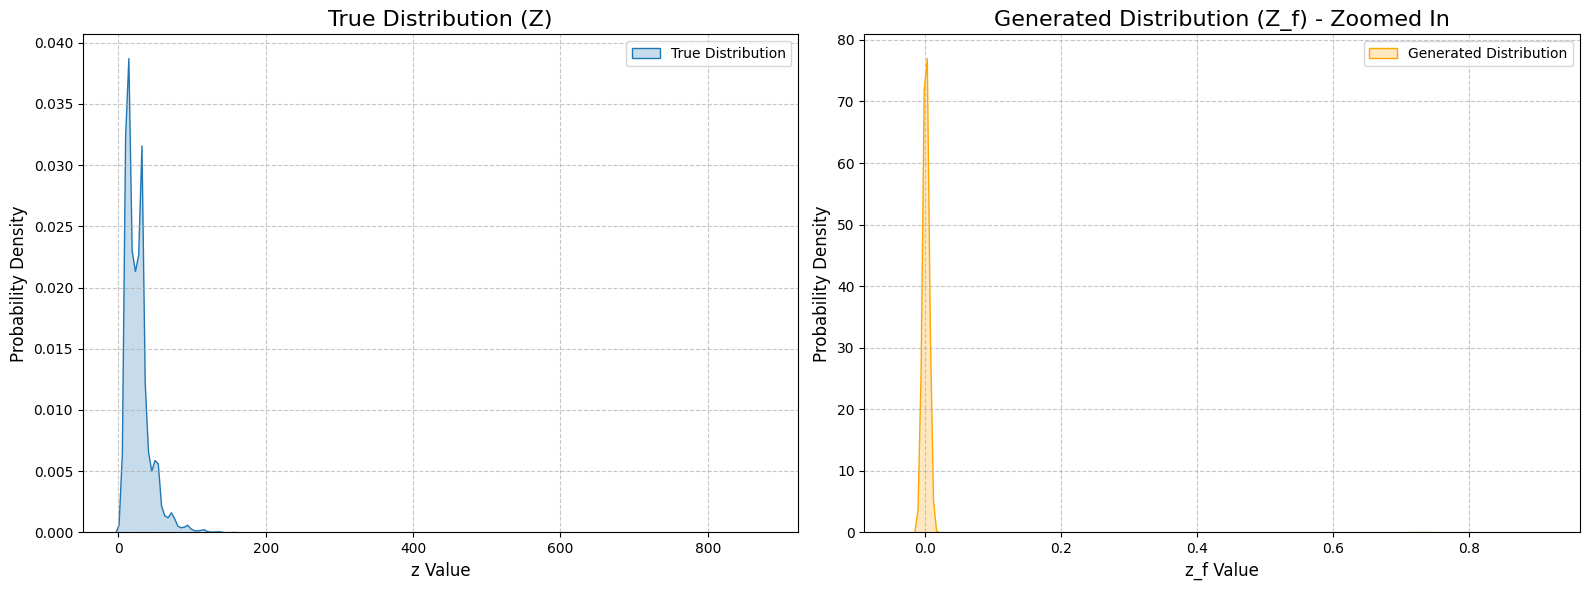

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: True Distribution (z)
sns.kdeplot(z.flatten(), ax=axes[0], label='True Distribution', fill=True)
axes[0].set_title('True Distribution (Z)', fontsize=16)
axes[0].set_xlabel('z Value', fontsize=12)
axes[0].set_ylabel('Probability Density', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Generated Distribution (z_f) - Zoomed in
sns.kdeplot(z_f.flatten(), ax=axes[1], label='Generated Distribution', fill=True, color='orange')
axes[1].set_title('Generated Distribution (Z_f) - Zoomed In', fontsize=16)
axes[1].set_xlabel('z_f Value', fontsize=12)
axes[1].set_ylabel('Probability Density', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Adjust x-axis limits for the generated distribution to make it more visible
# This will typically be a very small range around zero due to the Tanh activation
# We'll use the actual min/max of z_f to define the limits more precisely
z_f_min = z_f.min()
z_f_max = z_f.max()
if z_f_min == z_f_max: # Handle case where all values are identical
    axes[1].set_xlim(z_f_min - 0.001, z_f_max + 0.001)
else:
    axes[1].set_xlim(z_f_min - (z_f_max - z_f_min) * 0.1, z_f_max + (z_f_max - z_f_min) * 0.1)


plt.tight_layout()
plt.show()